# Main Aggregation Script - calls lab.py and crystals.py

In [13]:
#Reloads the lab.py and crystals.py modules to update any changes (after saving)
#If a new method or object is created, autoreload doesn't work and the 
#kernel needs to be closed and halted after saving and making a 'checkpoint'
#in this notebook

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import ipas 
import numpy as np
import dask
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
from dask import delayed
from dask import dataframe as dd
import functools
import sys
import ast
from struct import *
import pickle
import glob
import random
import pandas as pd
import time
from dask.distributed import as_completed
from joblib import Parallel, delayed, parallel_backend

In [4]:
cluster = SLURMCluster(
    queue='kratos',
    walltime='04-23:00:00',
    cores=1,
    memory='20000MiB', #1 GiB = 1,024 MiB
    processes=1)

#cluster.adapt(minimum=3, maximum=20)
cluster.scale(10)

/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [5]:
client = Client(cluster)

In [15]:
client

<Client: 'tcp://169.226.65.51:36431' processes=10 threads=10, memory=209.70 GB>

# Initialize databases for queries

In [18]:
files = ['sqlite:///'+f for f in glob.glob("db_files/IPAS_*_lastmono.sqlite")]
tables = ['aggregates', 'crystals']

In [19]:
%%time

df=[]
for table in tables:
    
    #read tables in parallel on client 
    read_files = [dask.delayed(dd.read_sql_table)(table=table, uri=file, index_col='id') for file in files]
    
    compute_read = client.compute(read_files)
    print('done with compute')
    ddfs = client.gather(compute_read)
    print('done with gather')
    #concatenate all sqlite files vertically (axis=0 default) (same columns)
    gathered_reads = client.scatter(ddfs)
    ddf = client.submit(dd.concat, gathered_reads).result()
    print('done with submit')
    #append combined dask df for each table
    df.append(ddf)


done with compute
done with gather
done with submit
done with compute
done with gather
done with submit
CPU times: user 3.7 s, sys: 390 ms, total: 4.09 s
Wall time: 55.6 s


In [20]:
%time df_concat = dd.concat([df[0], df[1]], axis=1)

CPU times: user 3.92 ms, sys: 982 µs, total: 4.9 ms
Wall time: 5.17 ms


/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/dask/dataframe/multi.py:1055: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indexes of each dataframes are 
 aligned. This assumption is not generally safe.
  "Concatenating dataframes with unknown divisions.\n"


In [21]:
df_concat.agg_r = np.power((np.power(df_concat.a, 2) * df_concat.c), (1./3.))

In [22]:
def query_r_5000(df):
    return df[df.agg_r < 5000]

df_concat = df_concat.map_partitions(query_r_5000)
#len(df_concat) #86% of dataset

In [23]:
df_repart = df_concat.repartition(partition_size="100MB").persist()
df_repart.npartitions

48

# MAIN

In [24]:
ch_dist='gamma'         #anything other than gamma uses the characteristic from the best distribution pdf (lowest SSE)
rand_orient = False   #randomly orient the seed crystal and new crystal: uses first random orientation
save_plots = False     #saves all histograms to path with # of aggs and minor/depth folder

#Note, there may be a shape parameter erlang distribution run time warning occasionally if warning filter
#is turned off, disregard it
#warnings.filterwarnings("ignore")


In [25]:
def query_ncrystals(df_phi, r_bins):
    avg_ncrystals = []
    for r in range(len(r_bins)-1):
        df = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1])]
        avg_ncrystals.append(df.ncrystals.mean().compute())
    return avg_ncrystals

def concatenate_points(agg):
    points = []
    ncrystals = agg.ncrystals.values[0]
    agg_id = agg.agg_id.values[0]
    #print('ncrystals, phi, r, agg_id')

    while ncrystals >= 2:
        query = df_repart[(df_repart.r == agg.r.values[0]) & (df_repart.phi == agg.phi.values[0]) & \
                     (df_repart.ncrystals == ncrystals) & (df_repart.agg_id == agg_id)].compute()

        #print(query.ncrystals.values[0], query.phi.values[0], query.r.values[0], query.agg_id.values[0])

        points.append(pickle.loads(query.points.values[0]))
        ncrystals -= 1
        agg_id -= 1

    cluster_points = np.concatenate(points)
    cluster_points = np.reshape(cluster_points, (int(np.shape(cluster_points)[0]/12), 12))
    cluster_points = np.array(cluster_points, dtype=[('x', float), ('y', float), ('z', float)])        
        
    return cluster_points

In [26]:
def concatenate_points_all(agg):
    
    hold_points = []
    
    cluster = ipas.Cluster_Calculations(agg)
    ncrystals = agg.ncrystals
    
    print('ncrystals', ncrystals)
    agg_id = agg.agg_id
    #print('ncrystals, phi, r, agg_id', ncrystals, agg_id, agg_id-ncrystals)
    
    query = df_repart[(df_repart.r == agg.r) & (df_repart.phi == agg.phi) & \
                     (df_repart.ncrystals >= 2) & (df_repart.ncrystals <= ncrystals) &\
                     (df_repart.agg_id <= agg_id) & (df_repart.agg_id >= agg_id-ncrystals)].compute()
    for points in query.points:
        hold_points.append(pickle.loads(query.points.values[0]))

    cluster.points = np.concatenate(hold_points)
    cluster.points = np.reshape(cluster.points, (int(np.shape(cluster.points)[0]/12), 12))
    cluster.points = np.array(cluster.points, dtype=[('x', float), ('y', float), ('z', float)])        


#     points = np.concatenate(hold_points)
#     points = np.reshape(points, (int(np.shape(cluster.points)[0]/12), 12))
#     points = np.array(points, dtype=[('x', float), ('y', float), ('z', float)])    
 
    return cluster

In [37]:
def main():
    
    output = []
    hold_clusters  = []
    res, phi_bins = pd.qcut(df_repart.agg_phi.compute(), 20, retbins=True)
    #print(phi_bins)
    for i in range(len(phi_bins)-1):
        
        if i < 4:
        
            #print('phi_bin = ', phi_bins[i], phi_bins[i+1])
            #return a df that only queries within an aspect ratio bin
            df_phi = df_repart[(df_repart.agg_phi > phi_bins[i]) & (df_repart.agg_phi < phi_bins[i+1]) & \
                              (df_repart.ncrystals > 5)]  #to ensure at least 2 crystals within agg since ncrystals=1 not in db
            #now break that aspect ratio bin into 20 equal r bins
            res, r_bins = pd.qcut(df_phi.agg_r.compute(), 20, retbins=True)
            #print(r_bins)

            for r in range(len(r_bins)-1):
                
                if r > 4:
                    print('i, r ',i, r)


                    print('r = ', r_bins[r], r_bins[r+1])
                    df_r = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1]) &\
                                    (df_phi.ncrystals > 5)].compute() 

                    #print(df_repart.id.value_counts().compute().head(30))         

                    #start_time = time.time()
                    clusters = df_r.sample(3)

                    #print('time to pull samples = ', (time.time()-start_time))

                    start_time = time.time()
                    hold_clusters = []
                    for agg in clusters.itertuples():
                        cluster = concatenate_points_all(agg)
                        hold_clusters.append(cluster)


                #print('time to concatenate all pts = ', (time.time()-start_time))

    #             start_time = time.time()
    #             delayeds = []
    #             for agg in clusters.itertuples():
    #                 #print(agg)
    #                 delayeds.append(delayed(concatenate_points_all)(agg))
    #             #print('delayeds', delayeds)
    #             hold_clusters = dask.compute(*delayeds)

                #print('after comppute', hold_clusters)


    #             for agg, points in zip(clusters, hold_points):
    #                 cluster = ipas.Cluster_Calculations(agg)
    #                 cluster.points = points
    #                 hold_clusters.append(cluster)
    #                 print('compute', cluster)


               # print('time to concatenate all pts = ', (time.time()-start_time))

#                 cluster_count=0
#                 clusters = []
#                 start_time = time.time()
#                 while cluster_count <= sample_size:
#                     agg = df_r.sample(1) 
#                     cluster_points = concatenate_points(agg)
#                     cluster = ipas.Cluster_Calculations(agg)  #calls parent class init of Ice_Cluster
#                     cluster.points = cluster_points
#                     cluster.plates = True if agg.agg_phi.values[0] < 1.0 else False
#                     try:
#                         cluster.projectxy()  #check that all monomers are connected
#                         clusters.append(cluster)
#                         cluster_count+=1
#                     except ValueError:
#                         print('bad')

#                 print('time to pull 300 samples = ', (time.time()-start_time))
    
            #output.append(delayed(ipas.collect_clusters)(hold_clusters, rand_orient=rand_orient))     
            #output.append(hold_clusters)
                    %time output.append(ipas.collect_clusters(hold_clusters, rand_orient=rand_orient))

    return hold_clusters
    

i, r  0 5
r =  44.881750275335904 54.80548292501528
ncrystals 47
ncrystals 37
ncrystals 31
nclusters 1 0 23
clus 2 36
cluster3 ncrystals 46 36 82
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
clus 1
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71
crys 72
crys 73
crys 74
crys 75
crys 76
crys 77
crys 78
crys 79
crys 80
crys 81


clus 2 30
cluster3 ncrystals 36 30 66
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
clus 1
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65


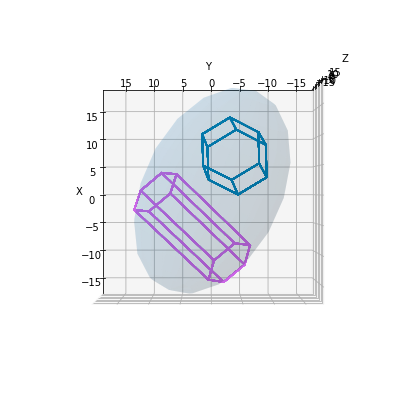

IndexError: list index out of range

i, r  0 6
r =  54.80548292501528 67.08814721318912
ncrystals 41
ncrystals 29
ncrystals 32
nclusters 1 0 23
clus 2 28
cluster3 ncrystals 40 28 68
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
clus 1
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67


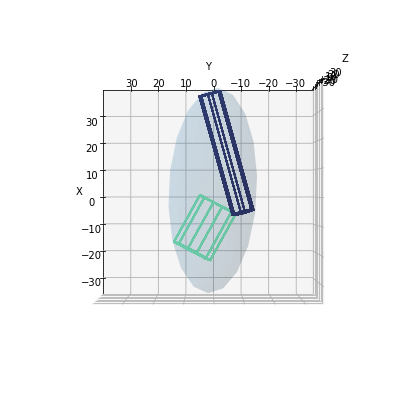

clus 2 31
cluster3 ncrystals 28 31 59
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
clus 1
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58


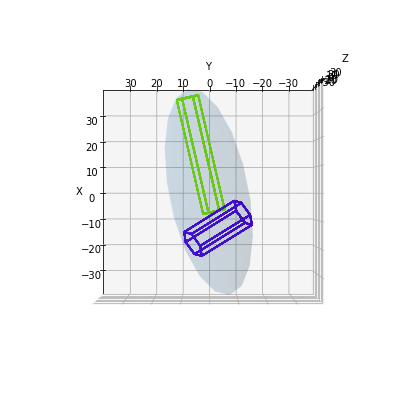

IndexError: list index out of range

i, r  0 7
r =  67.08814721318912 90.5722793150313
ncrystals 26
ncrystals 49
ncrystals 47
nclusters 1 0 23
clus 2 48
cluster3 ncrystals 25 48 73
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
clus 1
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71
crys 72


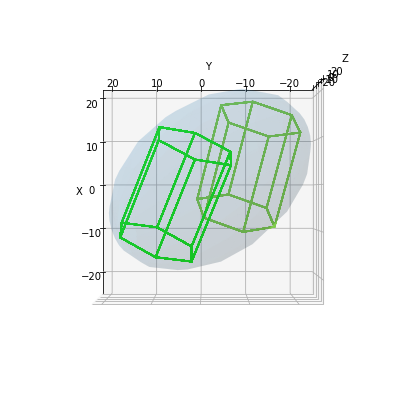

clus 2 46
cluster3 ncrystals 48 46 94
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
clus 1
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71
crys 72
crys 73
crys 74
crys 75
crys 76
crys 77
crys 78
crys 79
crys 80
crys 81
crys 82
crys 83
crys 84
crys 85
crys 86
crys 87
crys 88
crys 89
crys 90
crys 91
crys 92
crys 93


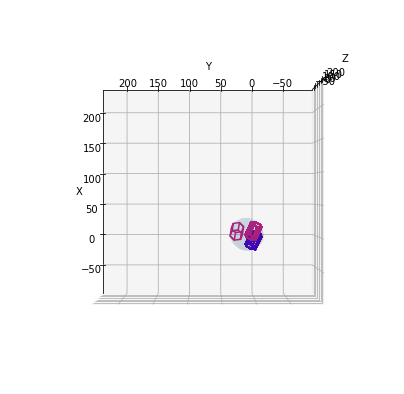

IndexError: list index out of range

i, r  0 8
r =  90.5722793150313 177.87865664426303
ncrystals 20
ncrystals 22
ncrystals 44
nclusters 1 0 23
clus 2 21
cluster3 ncrystals 19 21 40
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
clus 1
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39


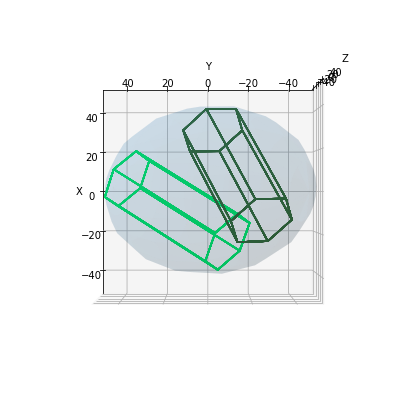

clus 2 43
cluster3 ncrystals 21 43 64
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
clus 1
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63


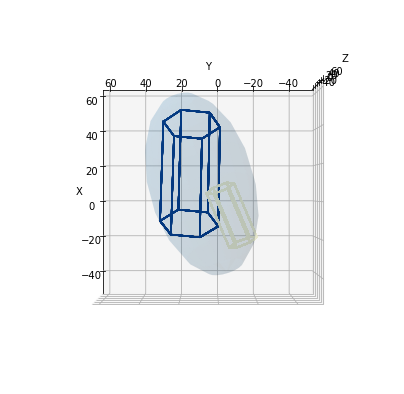

IndexError: list index out of range

i, r  0 9
r =  177.87865664426303 263.7923138065977
ncrystals 14
ncrystals 9
ncrystals 13
nclusters 1 0 23
clus 2 8
cluster3 ncrystals 13 8 21
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
clus 1
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20


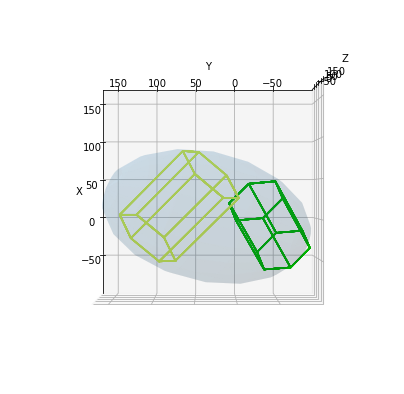

clus 2 12
cluster3 ncrystals 8 12 20
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
clus 1
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19


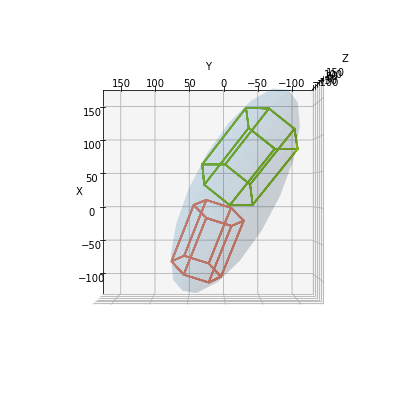

IndexError: list index out of range

i, r  0 10
r =  263.7923138065977 346.6751390028233
ncrystals 16
ncrystals 24
ncrystals 19
nclusters 1 0 23
clus 2 23
cluster3 ncrystals 15 23 38
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
clus 1
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37


KeyboardInterrupt: 

i, r  0 11
r =  346.6751390028233 428.7847641808312
ncrystals 47
ncrystals 17
ncrystals 21
nclusters 1 0 23
clus 2 16
cluster3 ncrystals 46 16 62
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
clus 1
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61


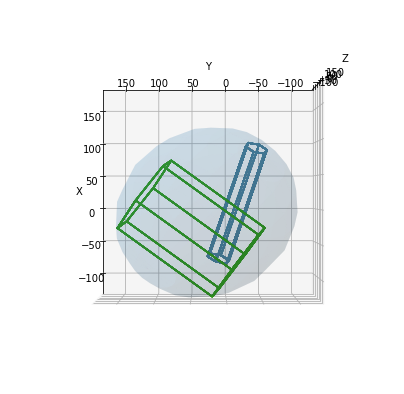

clus 2 20
cluster3 ncrystals 16 20 36
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
clus 1
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35


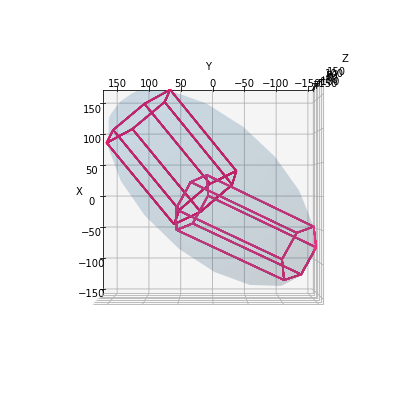

IndexError: list index out of range

i, r  0 12
r =  428.7847641808312 516.375208487133
ncrystals 20
ncrystals 46
ncrystals 45
nclusters 1 0 23
clus 2 45
cluster3 ncrystals 19 45 64
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
clus 1
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63


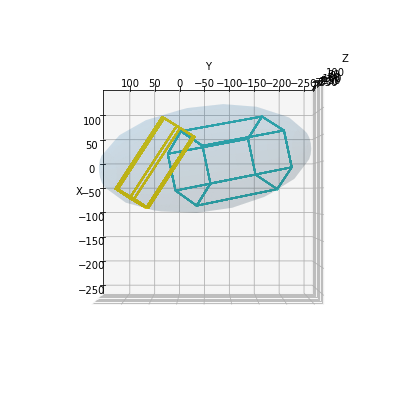

clus 2 44
cluster3 ncrystals 45 44 89
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
clus 1
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71
crys 72
crys 73
crys 74
crys 75
crys 76
crys 77
crys 78
crys 79
crys 80
crys 81
crys 82
crys 83
crys 84
crys 85
crys 86
crys 87
crys 88


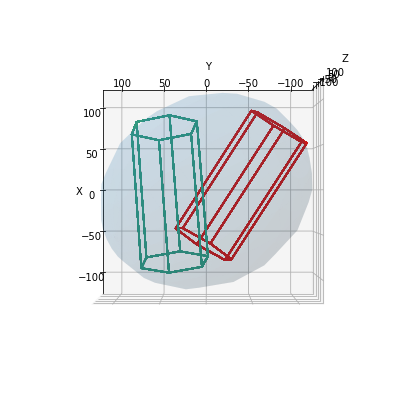

IndexError: list index out of range

i, r  0 13
r =  516.375208487133 612.8246289872807
ncrystals 38
ncrystals 37
ncrystals 21
nclusters 1 0 23
clus 2 36
cluster3 ncrystals 37 36 73
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
clus 1
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71
crys 72


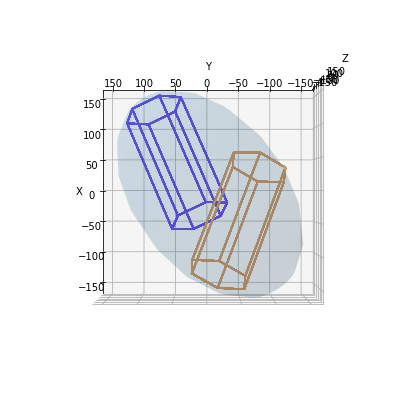

clus 2 20
cluster3 ncrystals 36 20 56
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
clus 1
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55


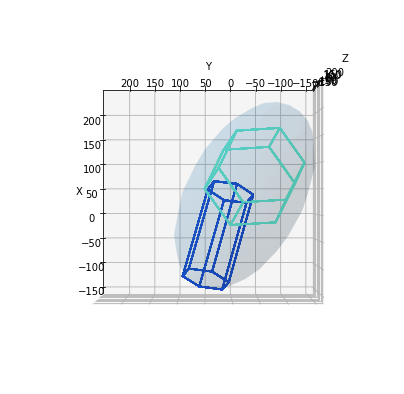

IndexError: list index out of range

i, r  0 14
r =  612.8246289872807 731.8623273606278
ncrystals 36
ncrystals 50
ncrystals 37
nclusters 1 0 23
clus 2 49
cluster3 ncrystals 35 49 84
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
clus 1
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71
crys 72
crys 73
crys 74
crys 75
crys 76
crys 77
crys 78
crys 79
crys 80
crys 81
crys 82
crys 83


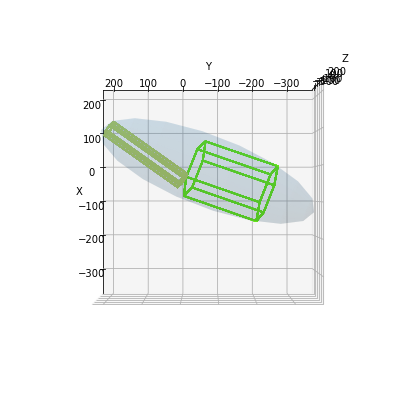

clus 2 36
cluster3 ncrystals 49 36 85
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
clus 1
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71
crys 72
crys 73
crys 74
crys 75
crys 76
crys 77
crys 78
crys 79
crys 80
crys 81
crys 82
crys 83
crys 84


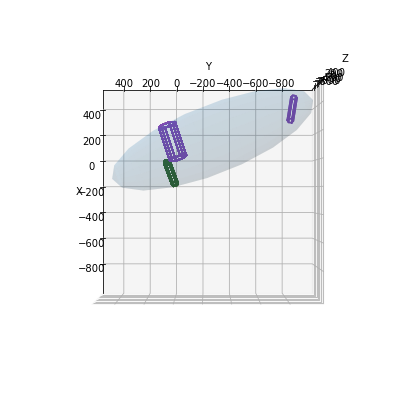

IndexError: list index out of range

i, r  0 15
r =  731.8623273606278 913.91503773086
ncrystals 47
ncrystals 45
ncrystals 39
nclusters 1 0 23
clus 2 44
cluster3 ncrystals 46 44 90
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
clus 1
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71
crys 72
crys 73
crys 74
crys 75
crys 76
crys 77
crys 78
crys 79
crys 80
crys 81
crys 82
crys 83
crys 84
crys 85
crys 86
crys 87
crys 88
crys 89


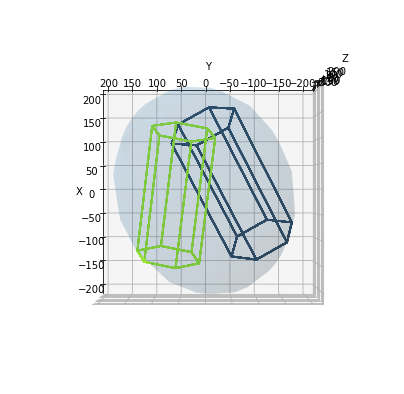

clus 2 38
cluster3 ncrystals 44 38 82
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
clus 1
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71
crys 72
crys 73
crys 74
crys 75
crys 76
crys 77
crys 78
crys 79
crys 80
crys 81


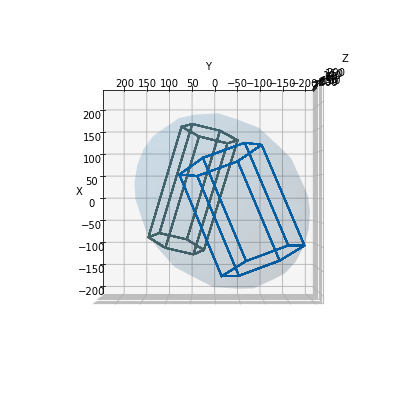

IndexError: list index out of range

i, r  0 16
r =  913.91503773086 1829.415148819151
ncrystals 34
ncrystals 38
ncrystals 22
nclusters 1 0 23
clus 2 37
cluster3 ncrystals 33 37 70
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
clus 1
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69


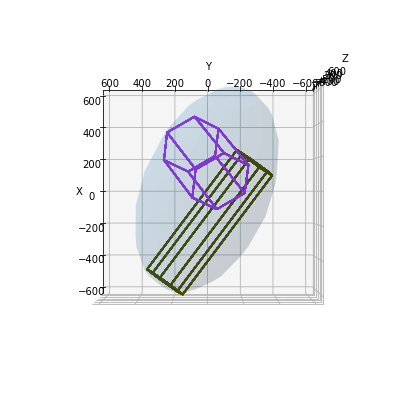

clus 2 21
cluster3 ncrystals 37 21 58
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
clus 1
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57


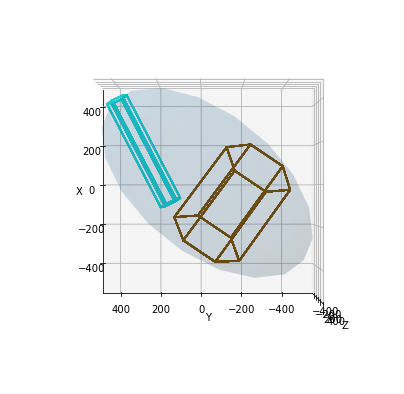

IndexError: list index out of range

i, r  0 17
r =  1829.415148819151 3264.7899541241204
ncrystals 45
ncrystals 36
ncrystals 48
nclusters 1 0 23
clus 2 35
cluster3 ncrystals 44 35 79
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
clus 1
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71
crys 72
crys 73
crys 74
crys 75
crys 76
crys 77
crys 78


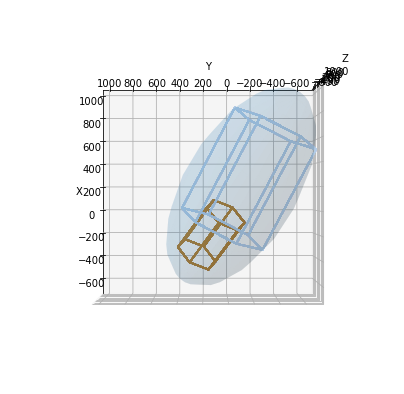

clus 2 47
cluster3 ncrystals 35 47 82
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
clus 1
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71
crys 72
crys 73
crys 74
crys 75
crys 76
crys 77
crys 78
crys 79
crys 80
crys 81


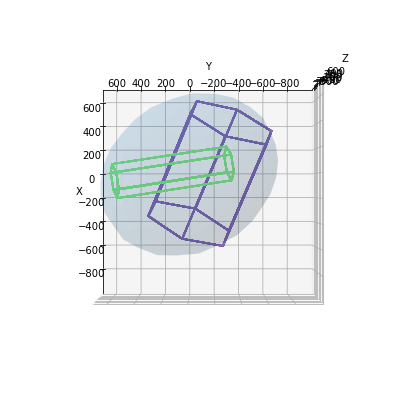

IndexError: list index out of range

i, r  0 18
r =  3264.7899541241204 4142.213209215065
ncrystals 22
ncrystals 28
ncrystals 48
nclusters 1 0 23
clus 2 27
cluster3 ncrystals 21 27 48
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
clus 1
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47


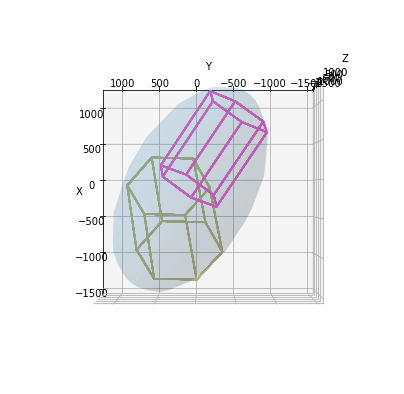

clus 2 47
cluster3 ncrystals 27 47 74
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
clus 1
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71
crys 72
crys 73


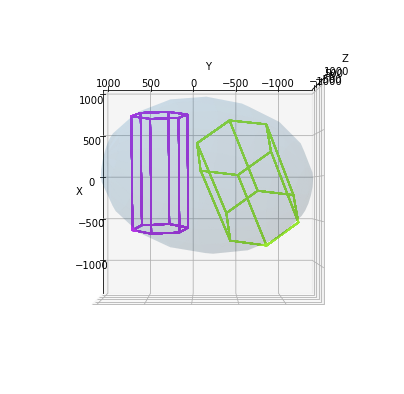

IndexError: list index out of range

i, r  0 19
r =  4142.213209215065 4999.912382037989
ncrystals 26
ncrystals 30
ncrystals 50
nclusters 1 0 23
clus 2 29
cluster3 ncrystals 25 29 54
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
clus 1
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53


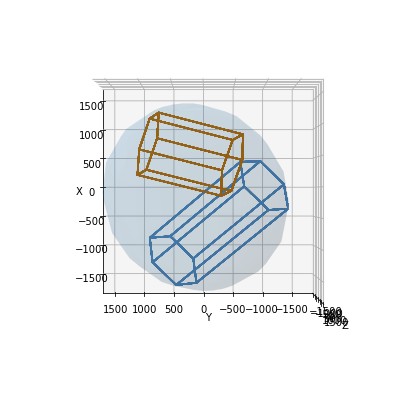

clus 2 49
cluster3 ncrystals 29 49 78
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
clus 1
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71
crys 72
crys 73
crys 74
crys 75
crys 76
crys 77


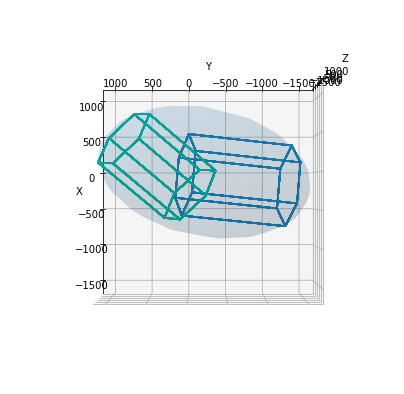

IndexError: list index out of range

i, r  1 5
r =  45.49385857876755 55.95361866677053
ncrystals 30
ncrystals 46
ncrystals 36
nclusters 1 0 23
clus 2 45
cluster3 ncrystals 29 45 74
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
clus 1
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71
crys 72
crys 73


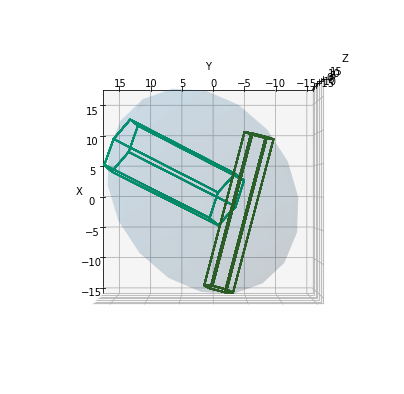

clus 2 35
cluster3 ncrystals 45 35 80
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
clus 1
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71
crys 72
crys 73
crys 74
crys 75
crys 76
crys 77
crys 78
crys 79


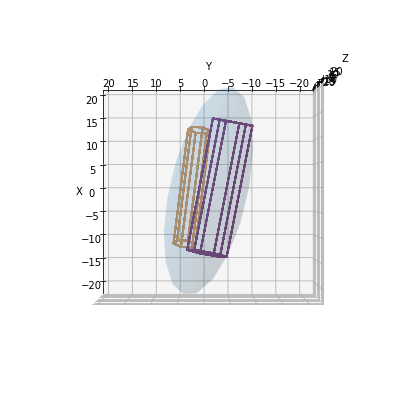

IndexError: list index out of range

i, r  1 6
r =  55.95361866677053 69.32811673923777
ncrystals 14
ncrystals 33
ncrystals 41
nclusters 1 0 23
clus 2 32
cluster3 ncrystals 13 32 45
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
clus 1
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44


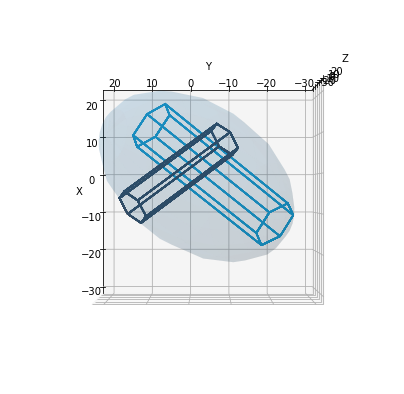

clus 2 40
cluster3 ncrystals 32 40 72
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
clus 1
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71


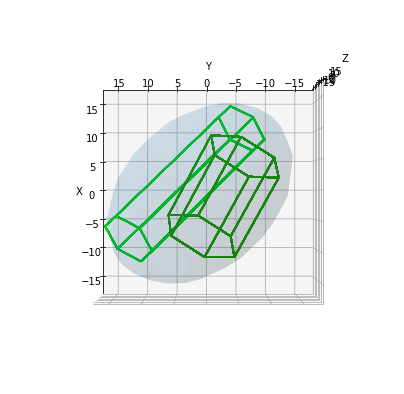

IndexError: list index out of range

i, r  1 7
r =  69.32811673923777 93.96459688762397
ncrystals 44
ncrystals 43
ncrystals 24
nclusters 1 0 23
clus 2 42
cluster3 ncrystals 43 42 85
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
clus 1
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71
crys 72
crys 73
crys 74
crys 75
crys 76
crys 77
crys 78
crys 79
crys 80
crys 81
crys 82
crys 83
crys 84


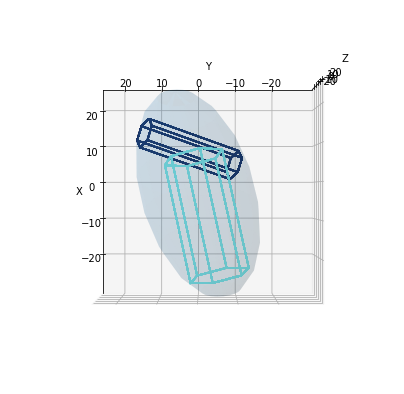

clus 2 23
cluster3 ncrystals 42 23 65
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
clus 1
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64


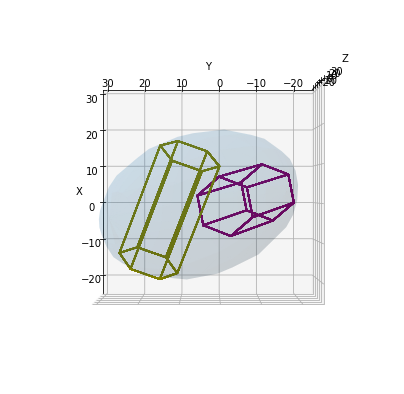

IndexError: list index out of range

i, r  1 8
r =  93.96459688762397 167.566553554677
ncrystals 29
ncrystals 12
ncrystals 40
nclusters 1 0 23
clus 2 11
cluster3 ncrystals 28 11 39
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
clus 1
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38


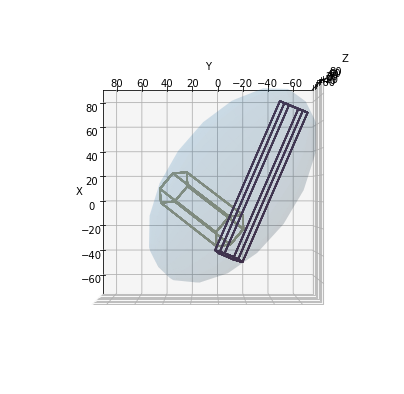

clus 2 39
cluster3 ncrystals 11 39 50
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
clus 1
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49


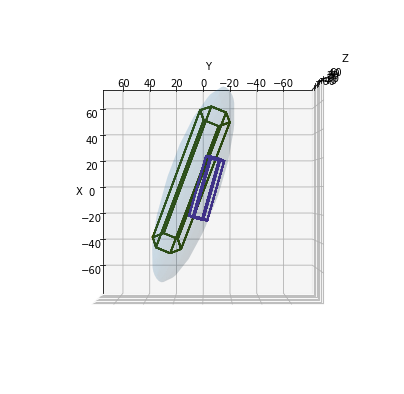

IndexError: list index out of range

i, r  1 9
r =  167.566553554677 247.4102162648525
ncrystals 14
ncrystals 27
ncrystals 48
nclusters 1 0 23
clus 2 26
cluster3 ncrystals 13 26 39
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
clus 1
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38


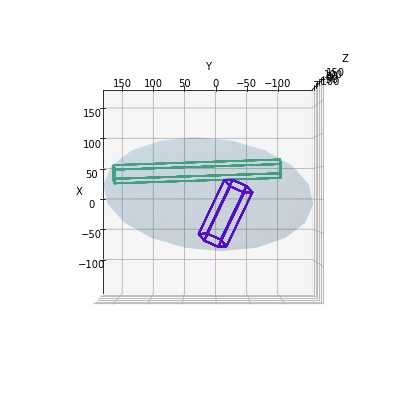

clus 2 47
cluster3 ncrystals 26 47 73
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
clus 1
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71
crys 72


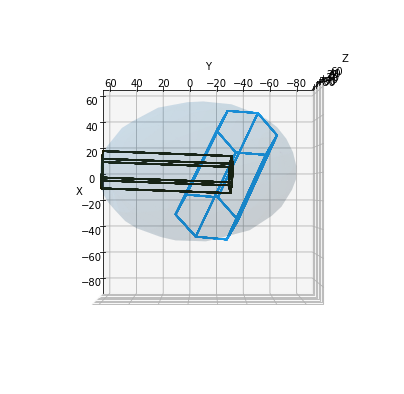

IndexError: list index out of range

i, r  1 10
r =  247.4102162648525 330.3031855252261
ncrystals 11
ncrystals 35
ncrystals 18
nclusters 1 0 23
clus 2 34
cluster3 ncrystals 10 34 44
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
clus 1
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43


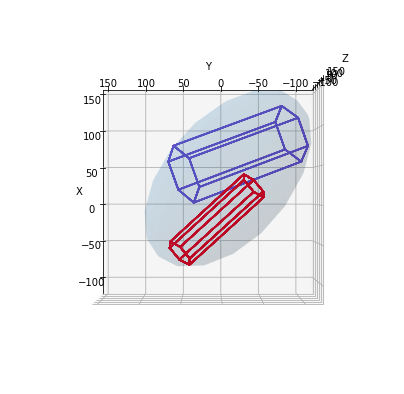

clus 2 17
cluster3 ncrystals 34 17 51
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
clus 1
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50


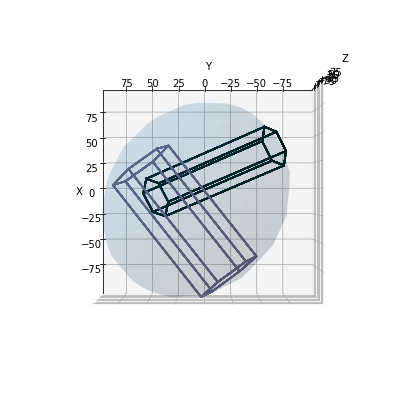

IndexError: list index out of range

i, r  1 11
r =  330.3031855252261 418.040260331276
ncrystals 46
ncrystals 20
ncrystals 31
nclusters 1 0 23
clus 2 19
cluster3 ncrystals 45 19 64
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
clus 1
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63


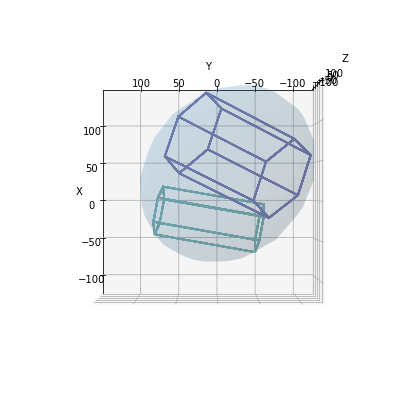

clus 2 30
cluster3 ncrystals 19 30 49
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
clus 1
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48


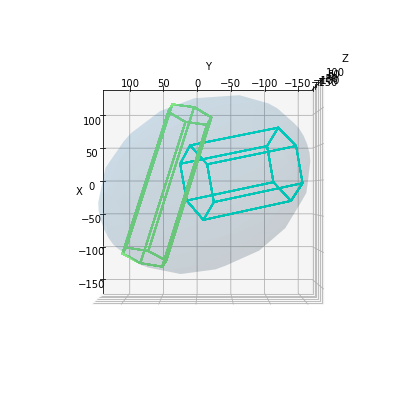

IndexError: list index out of range

i, r  1 12
r =  418.040260331276 512.0452319307554
ncrystals 23
ncrystals 25
ncrystals 21
nclusters 1 0 23
clus 2 24
cluster3 ncrystals 22 24 46
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
clus 1
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45


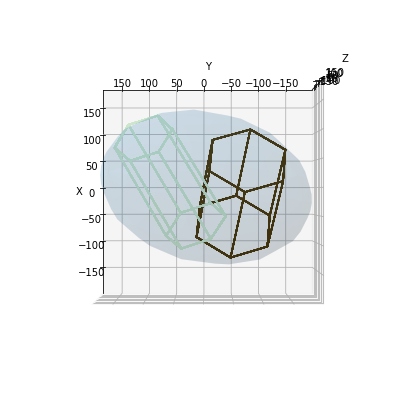

clus 2 20
cluster3 ncrystals 24 20 44
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
clus 1
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43


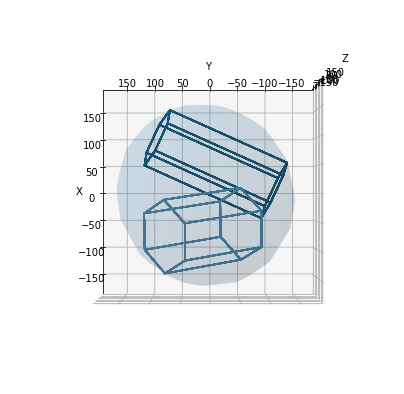

IndexError: list index out of range

i, r  1 13
r =  512.0452319307554 619.0562145233276
ncrystals 48
ncrystals 50
ncrystals 26
nclusters 1 0 23
clus 2 49
cluster3 ncrystals 47 49 96
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
clus 1
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71
crys 72
crys 73
crys 74
crys 75
crys 76
crys 77
crys 78
crys 79
crys 80
crys 81
crys 82
crys 83
crys 84
crys 85
crys 86
crys 87
crys 88
crys 89
crys 90
crys 91
crys 92
crys 93
crys 94
crys 95


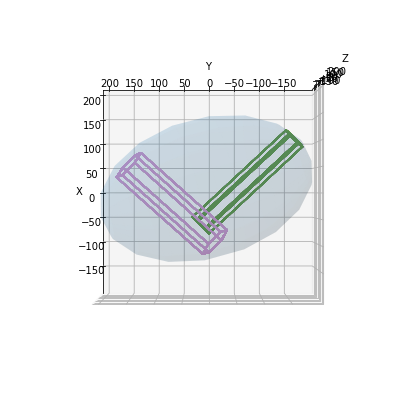

clus 2 25
cluster3 ncrystals 49 25 74
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
clus 1
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71
crys 72
crys 73


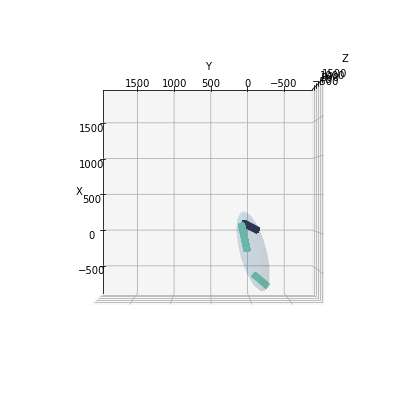

IndexError: list index out of range

i, r  1 14
r =  619.0562145233276 751.9576436697032
ncrystals 34
ncrystals 12
ncrystals 43
nclusters 1 0 23
clus 2 11
cluster3 ncrystals 33 11 44
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
clus 1
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43


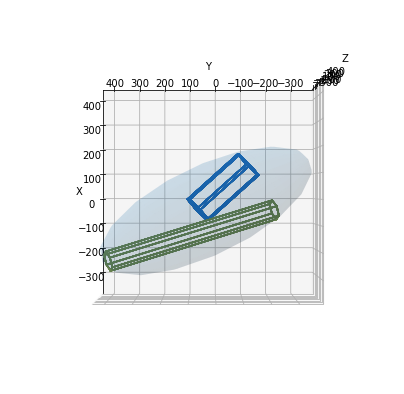

clus 2 42
cluster3 ncrystals 11 42 53
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
clus 1
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52


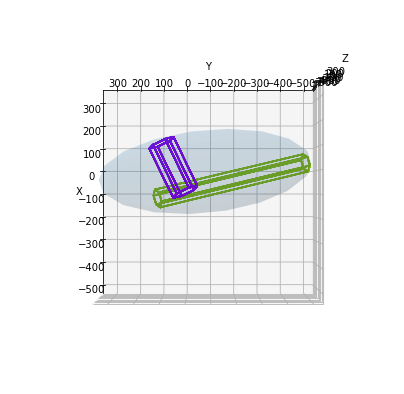

IndexError: list index out of range

i, r  1 15
r =  751.9576436697032 979.172376200257
ncrystals 30
ncrystals 37
ncrystals 45
nclusters 1 0 23
clus 2 36
cluster3 ncrystals 29 36 65
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
clus 1
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64


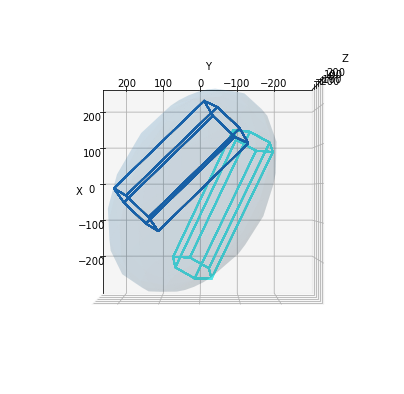

clus 2 44
cluster3 ncrystals 36 44 80
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
clus 1
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71
crys 72
crys 73
crys 74
crys 75
crys 76
crys 77
crys 78
crys 79


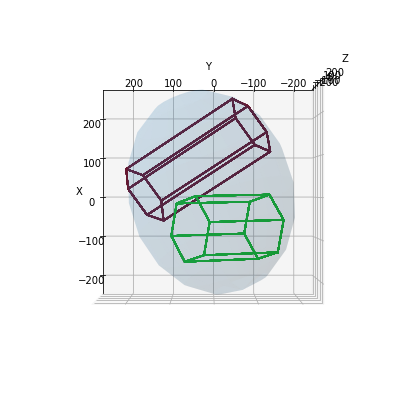

IndexError: list index out of range

i, r  1 16
r =  979.172376200257 1816.6798704047528
ncrystals 25
ncrystals 25
ncrystals 8
nclusters 1 0 23
clus 2 24
cluster3 ncrystals 24 24 48
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
clus 1
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47


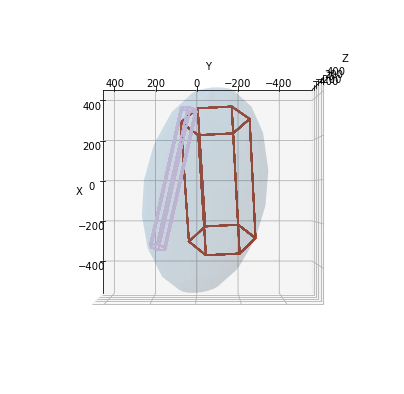

clus 2 7
cluster3 ncrystals 24 7 31
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
clus 1
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30


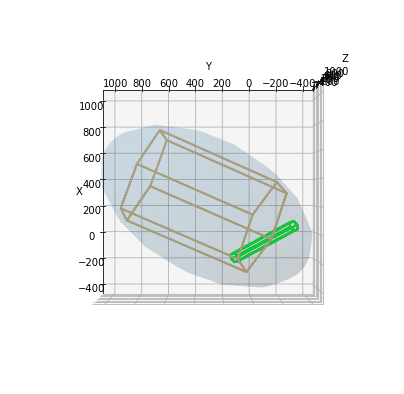

IndexError: list index out of range

i, r  1 17
r =  1816.6798704047528 3099.0762369652452
ncrystals 6
ncrystals 13
ncrystals 26
nclusters 1 0 23
clus 2 12
cluster3 ncrystals 5 12 17
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
clus 1
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16


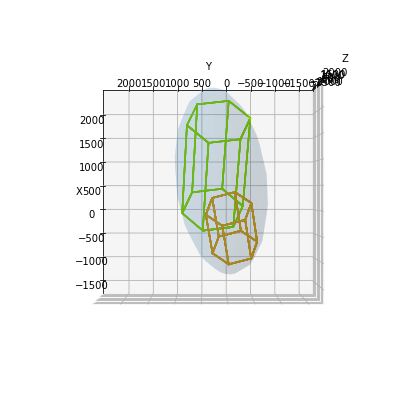

clus 2 25
cluster3 ncrystals 12 25 37
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
clus 1
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36


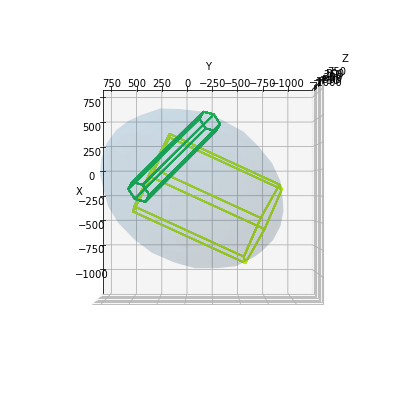

IndexError: list index out of range

i, r  1 18
r =  3099.0762369652452 4032.591107746331
ncrystals 27
ncrystals 18
ncrystals 20
nclusters 1 0 23
clus 2 17
cluster3 ncrystals 26 17 43
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
clus 1
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42


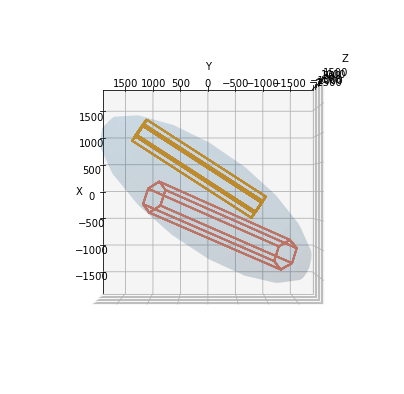

clus 2 19
cluster3 ncrystals 17 19 36
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
clus 1
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35


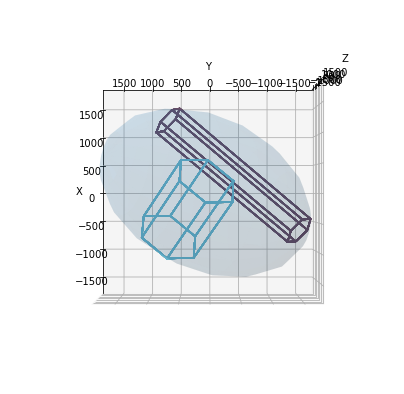

IndexError: list index out of range

i, r  1 19
r =  4032.591107746331 4999.938706937937
ncrystals 22
ncrystals 32
ncrystals 33
nclusters 1 0 23
clus 2 31
cluster3 ncrystals 21 31 52
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
clus 1
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51


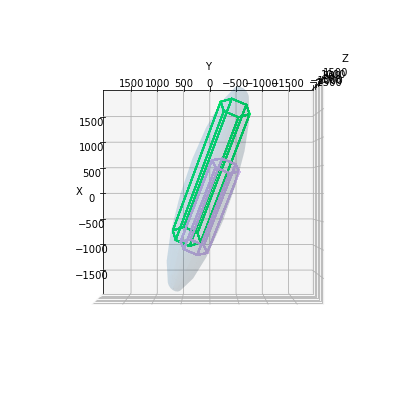

clus 2 32
cluster3 ncrystals 31 32 63
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
clus 1
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62


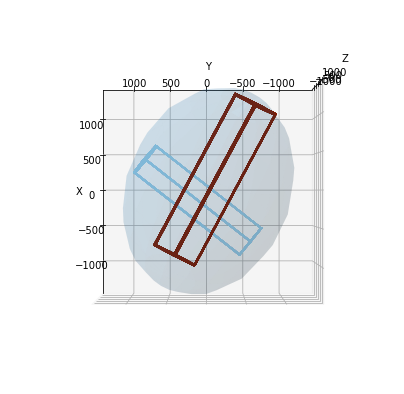

IndexError: list index out of range

i, r  2 5
r =  50.37234871843891 63.647896521649116
ncrystals 32
ncrystals 31
ncrystals 47
nclusters 1 0 23
clus 2 30
cluster3 ncrystals 31 30 61
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
clus 1
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60


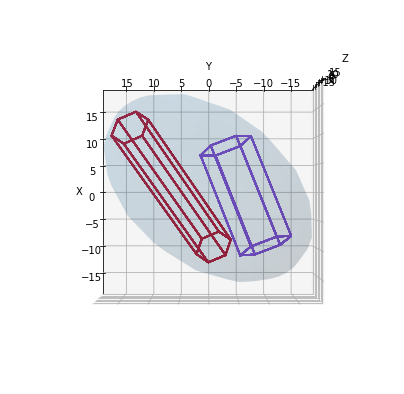

clus 2 46
cluster3 ncrystals 30 46 76
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
clus 1
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71
crys 72
crys 73
crys 74
crys 75


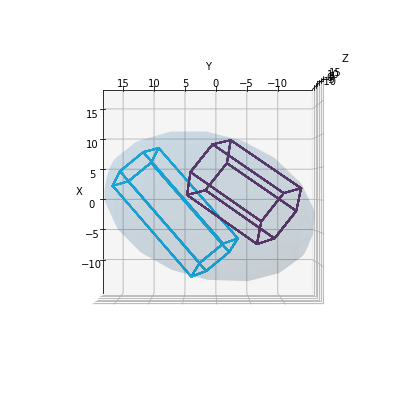

IndexError: list index out of range

i, r  2 6
r =  63.647896521649116 81.49167294579694
ncrystals 44
ncrystals 7
ncrystals 42
nclusters 1 0 23
clus 2 6
cluster3 ncrystals 43 6 49
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
clus 1
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48


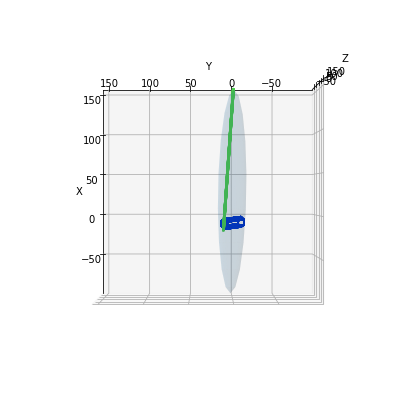

clus 2 41
cluster3 ncrystals 6 41 47
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
clus 1
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46


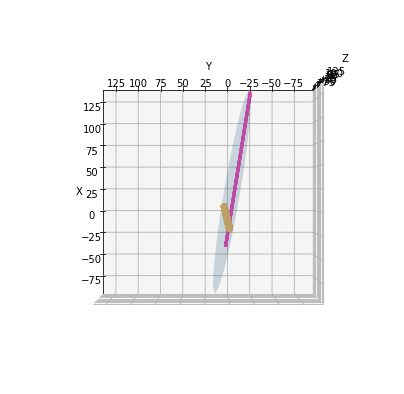

IndexError: list index out of range

i, r  2 7
r =  81.49167294579694 115.60219252931941
ncrystals 50
ncrystals 39
ncrystals 42
nclusters 1 0 23
clus 2 38
cluster3 ncrystals 49 38 87
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
clus 1
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71
crys 72
crys 73
crys 74
crys 75
crys 76
crys 77
crys 78
crys 79
crys 80
crys 81
crys 82
crys 83
crys 84
crys 85
crys 86


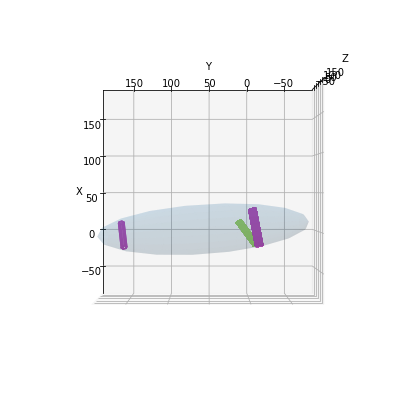

clus 2 41
cluster3 ncrystals 38 41 79
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
clus 1
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71
crys 72
crys 73
crys 74
crys 75
crys 76
crys 77
crys 78


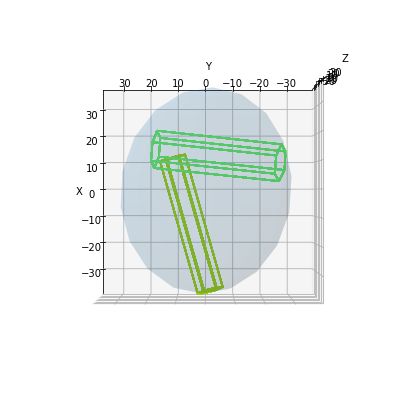

IndexError: list index out of range

i, r  2 8
r =  115.60219252931941 187.37692866834698
ncrystals 50
ncrystals 7
ncrystals 34
nclusters 1 0 23
clus 2 6
cluster3 ncrystals 49 6 55
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
clus 1
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54


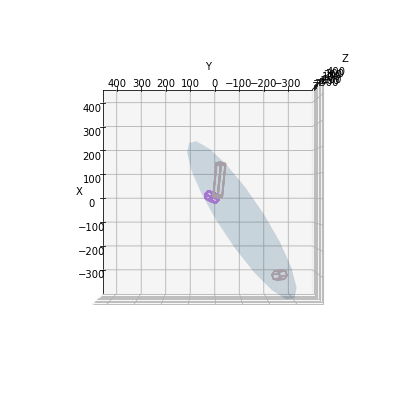

clus 2 33
cluster3 ncrystals 6 33 39
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
clus 1
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38


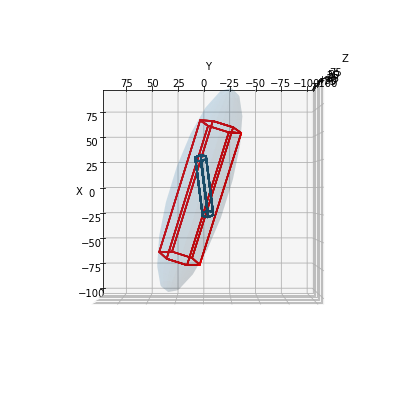

IndexError: list index out of range

i, r  2 9
r =  187.37692866834698 271.44617774438086
ncrystals 11
ncrystals 6
ncrystals 43
nclusters 1 0 23
clus 2 5
cluster3 ncrystals 10 5 15
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
clus 1
crys 10
crys 11
crys 12
crys 13
crys 14


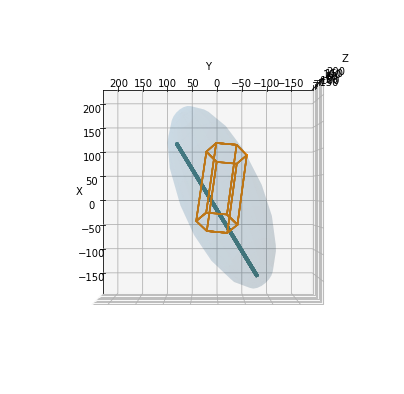

clus 2 42
cluster3 ncrystals 5 42 47
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
clus 1
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46


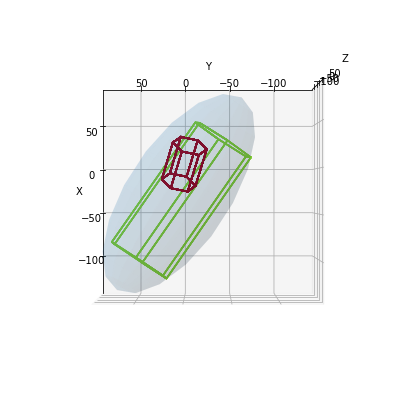

IndexError: list index out of range

i, r  2 10
r =  271.44617774438086 358.45851457198256
ncrystals 20
ncrystals 34
ncrystals 34
nclusters 1 0 23
clus 2 33
cluster3 ncrystals 19 33 52
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
clus 1
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51


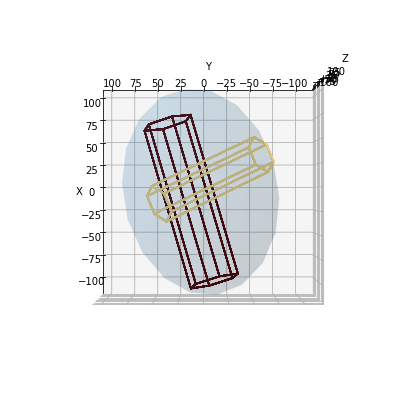

clus 2 33
cluster3 ncrystals 33 33 66
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
clus 1
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65


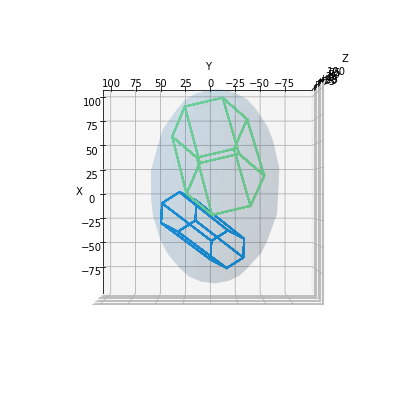

IndexError: list index out of range

i, r  2 11
r =  358.45851457198256 452.75158046041423
ncrystals 49
ncrystals 26
ncrystals 35
nclusters 1 0 23
clus 2 25
cluster3 ncrystals 48 25 73
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
clus 1
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71
crys 72


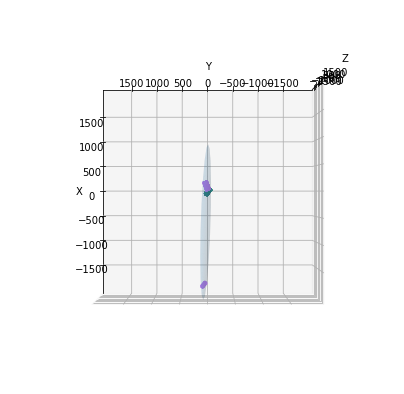

clus 2 34
cluster3 ncrystals 25 34 59
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
clus 1
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58


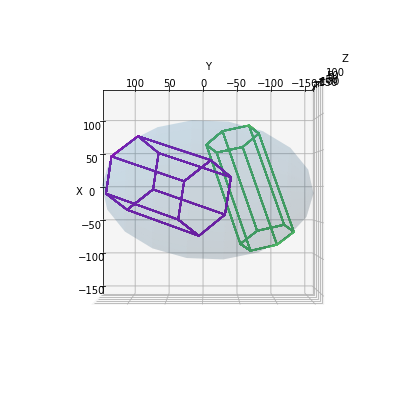

IndexError: list index out of range

i, r  2 12
r =  452.75158046041423 556.8270259342759
ncrystals 35
ncrystals 29
ncrystals 19
nclusters 1 0 23
clus 2 28
cluster3 ncrystals 34 28 62
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
clus 1
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61


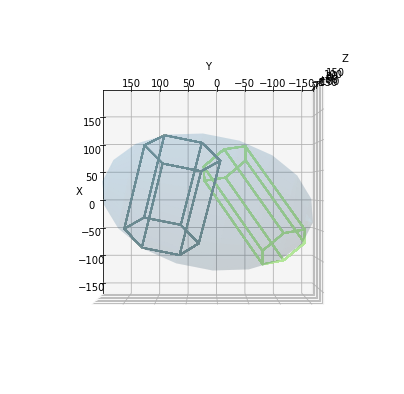

clus 2 18
cluster3 ncrystals 28 18 46
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
clus 1
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45


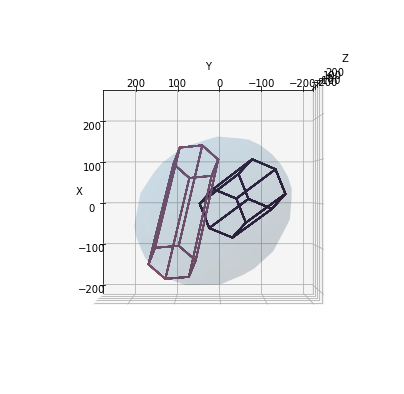

IndexError: list index out of range

i, r  2 13
r =  556.8270259342759 677.2124241089571
ncrystals 32
ncrystals 19
ncrystals 32
nclusters 1 0 23
clus 2 18
cluster3 ncrystals 31 18 49
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
clus 1
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48


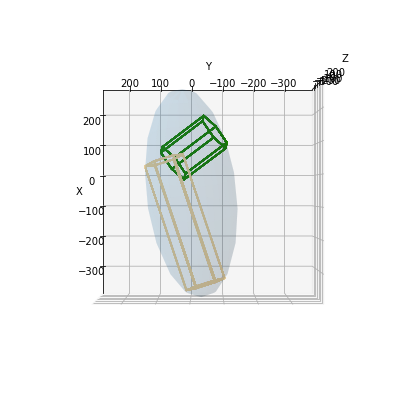

clus 2 31
cluster3 ncrystals 18 31 49
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
clus 1
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48


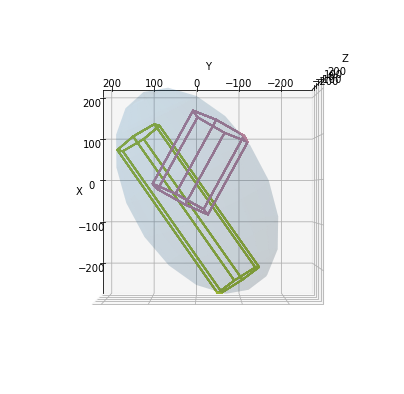

IndexError: list index out of range

i, r  2 14
r =  677.2124241089571 827.875087517871
ncrystals 40
ncrystals 44
ncrystals 49
nclusters 1 0 23
clus 2 43
cluster3 ncrystals 39 43 82
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
clus 1
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71
crys 72
crys 73
crys 74
crys 75
crys 76
crys 77
crys 78
crys 79
crys 80
crys 81


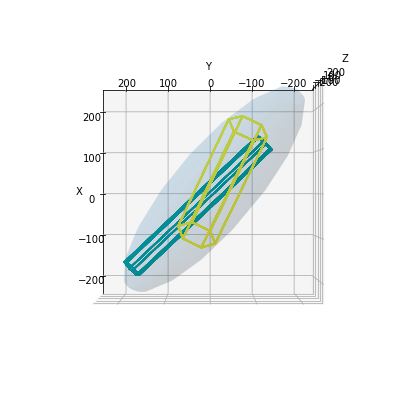

clus 2 48
cluster3 ncrystals 43 48 91
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
clus 1
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71
crys 72
crys 73
crys 74
crys 75
crys 76
crys 77
crys 78
crys 79
crys 80
crys 81
crys 82
crys 83
crys 84
crys 85
crys 86
crys 87
crys 88
crys 89
crys 90


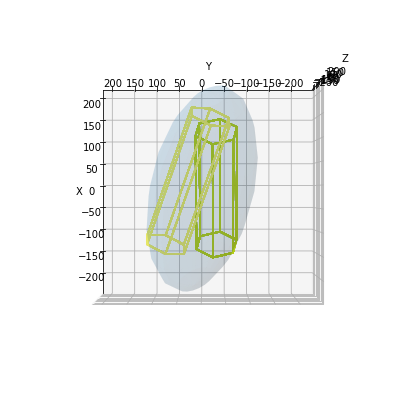

IndexError: list index out of range

i, r  2 15
r =  827.875087517871 1064.4348407824414
ncrystals 11
ncrystals 12
ncrystals 28
nclusters 1 0 23
clus 2 11
cluster3 ncrystals 10 11 21
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
clus 1
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20


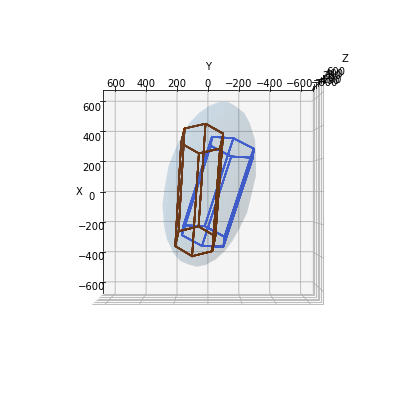

clus 2 27
cluster3 ncrystals 11 27 38
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
clus 1
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37


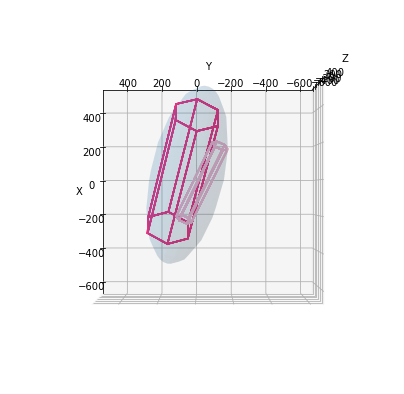

IndexError: list index out of range

i, r  2 16
r =  1064.4348407824414 1742.2913338701208
ncrystals 38
ncrystals 49
ncrystals 31
nclusters 1 0 23
clus 2 48
cluster3 ncrystals 37 48 85
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
clus 1
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71
crys 72
crys 73
crys 74
crys 75
crys 76
crys 77
crys 78
crys 79
crys 80
crys 81
crys 82
crys 83
crys 84


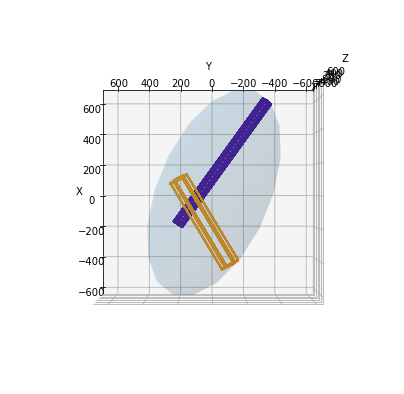

clus 2 30
cluster3 ncrystals 48 30 78
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
clus 1
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71
crys 72
crys 73
crys 74
crys 75
crys 76
crys 77


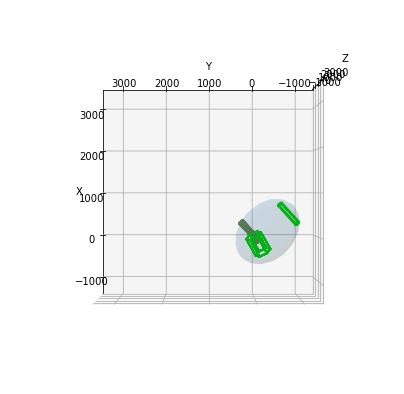

IndexError: list index out of range

i, r  2 17
r =  1742.2913338701208 2869.298383463834
ncrystals 28
ncrystals 43
ncrystals 48
nclusters 1 0 23
clus 2 42
cluster3 ncrystals 27 42 69
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
clus 1
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68


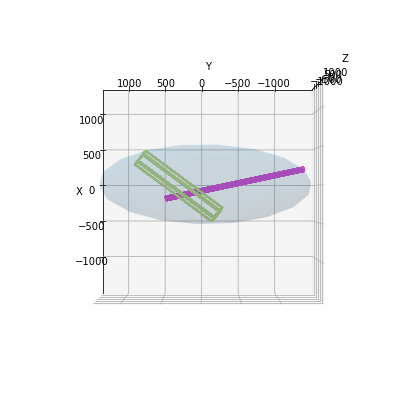

clus 2 47
cluster3 ncrystals 42 47 89
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
clus 1
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71
crys 72
crys 73
crys 74
crys 75
crys 76
crys 77
crys 78
crys 79
crys 80
crys 81
crys 82
crys 83
crys 84
crys 85
crys 86
crys 87
crys 88


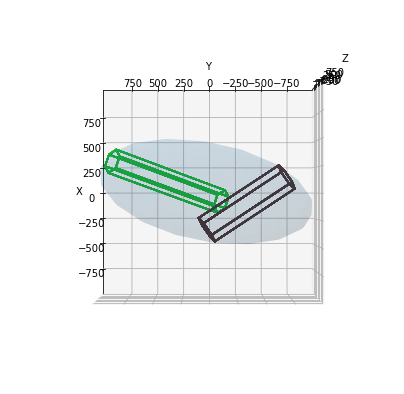

IndexError: list index out of range

i, r  2 18
r =  2869.298383463834 3973.735780117228
ncrystals 38
ncrystals 12
ncrystals 38
nclusters 1 0 23
clus 2 11
cluster3 ncrystals 37 11 48
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
clus 1
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47


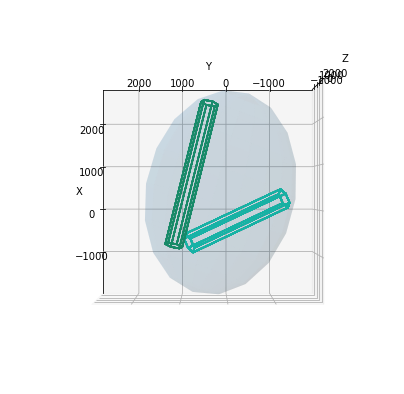

clus 2 37
cluster3 ncrystals 11 37 48
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
clus 1
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47


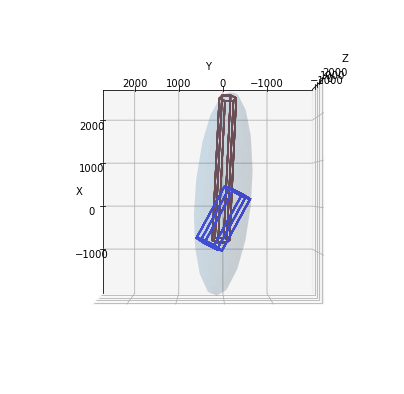

IndexError: list index out of range

i, r  2 19
r =  3973.735780117228 4999.817471112414
ncrystals 8
ncrystals 9
ncrystals 47
nclusters 1 0 23
clus 2 8
cluster3 ncrystals 7 8 15
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
clus 1
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14


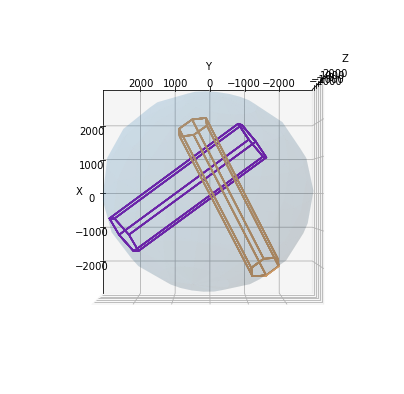

clus 2 46
cluster3 ncrystals 8 46 54
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
clus 1
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53


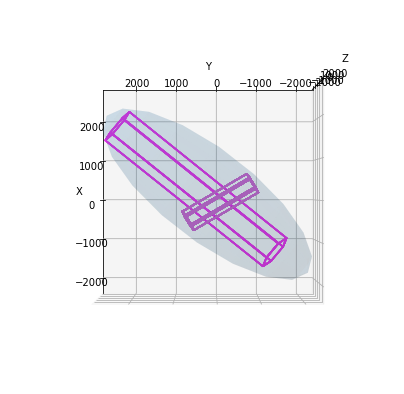

IndexError: list index out of range

i, r  3 5
r =  55.53818421972535 70.69373271789858
ncrystals 50
ncrystals 16
ncrystals 43
nclusters 1 0 23
clus 2 15
cluster3 ncrystals 49 15 64
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
clus 1
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63


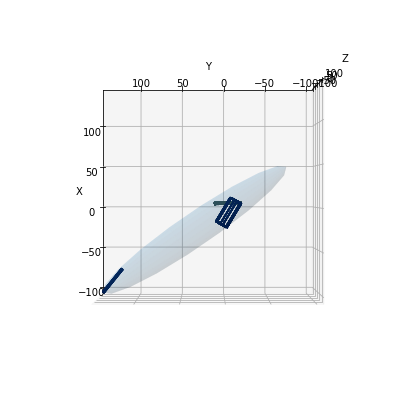

clus 2 42
cluster3 ncrystals 15 42 57
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
clus 1
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56


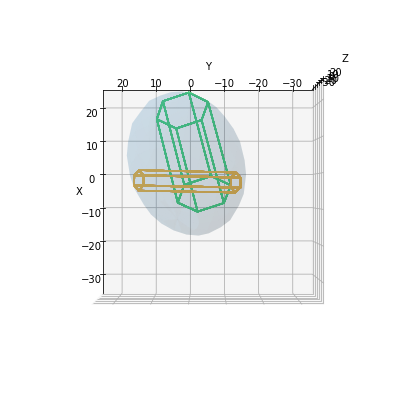

IndexError: list index out of range

i, r  3 6
r =  70.69373271789858 91.3463649296124
ncrystals 49
ncrystals 46
ncrystals 16
nclusters 1 0 23
clus 2 45
cluster3 ncrystals 48 45 93
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
clus 1
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71
crys 72
crys 73
crys 74
crys 75
crys 76
crys 77
crys 78
crys 79
crys 80
crys 81
crys 82
crys 83
crys 84
crys 85
crys 86
crys 87
crys 88
crys 89
crys 90
crys 91
crys 92


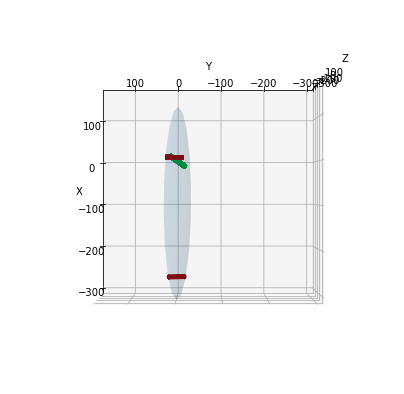

clus 2 15
cluster3 ncrystals 45 15 60
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
clus 1
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59


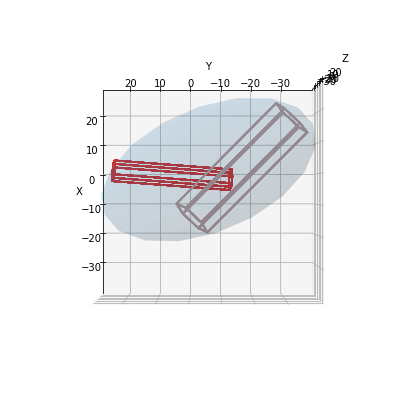

IndexError: list index out of range

i, r  3 7
r =  91.3463649296124 125.54531376484012
ncrystals 22
ncrystals 14
ncrystals 8
nclusters 1 0 23
clus 2 13
cluster3 ncrystals 21 13 34
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
clus 1
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33


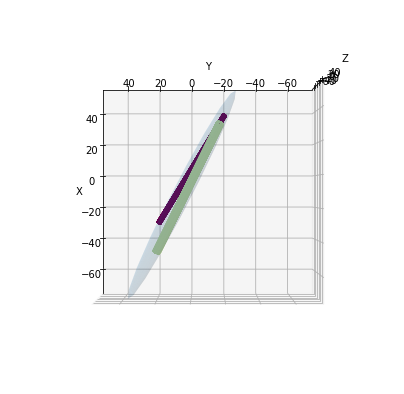

clus 2 7
cluster3 ncrystals 13 7 20
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
clus 1
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19


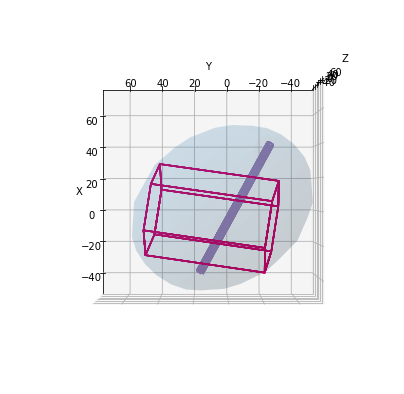

IndexError: list index out of range

i, r  3 8
r =  125.54531376484012 187.21947792381715
ncrystals 48
ncrystals 17
ncrystals 28
nclusters 1 0 23
clus 2 16
cluster3 ncrystals 47 16 63
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
clus 1
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62


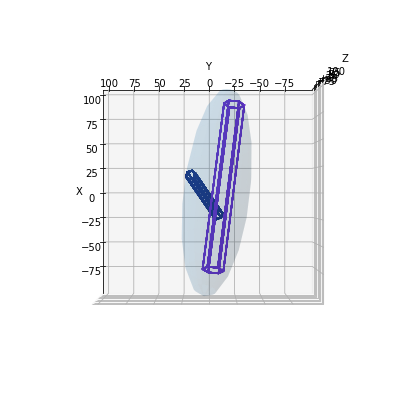

clus 2 27
cluster3 ncrystals 16 27 43
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
clus 1
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42


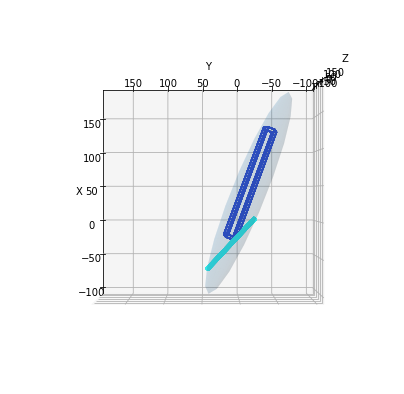

IndexError: list index out of range

i, r  3 9
r =  187.21947792381715 270.54644538111523
ncrystals 48
ncrystals 15
ncrystals 25
nclusters 1 0 23
clus 2 14
cluster3 ncrystals 47 14 61
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
clus 1
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60


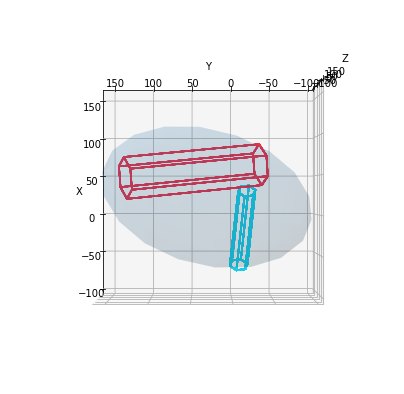

clus 2 24
cluster3 ncrystals 14 24 38
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
clus 1
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37


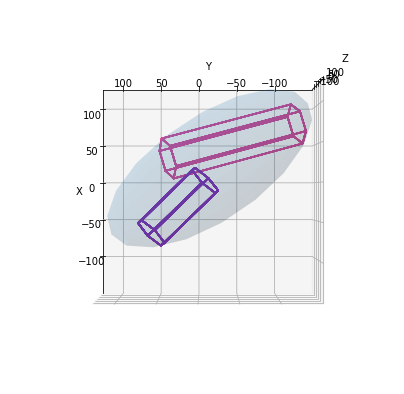

IndexError: list index out of range

i, r  3 10
r =  270.54644538111523 365.4130329942074
ncrystals 49
ncrystals 10
ncrystals 33
nclusters 1 0 23
clus 2 9
cluster3 ncrystals 48 9 57
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
clus 1
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56


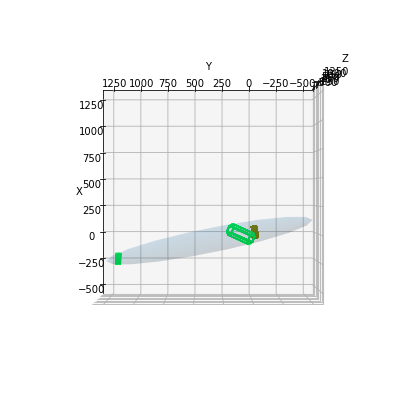

clus 2 32
cluster3 ncrystals 9 32 41
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
clus 1
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40


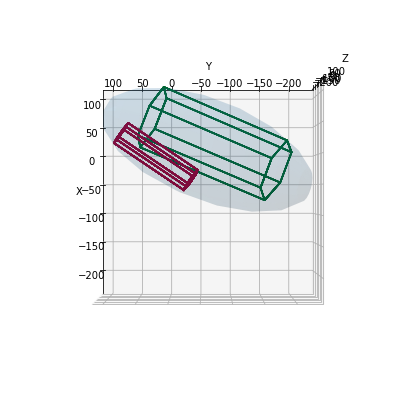

IndexError: list index out of range

i, r  3 11
r =  365.4130329942074 470.2280362599881
ncrystals 16
ncrystals 37
ncrystals 8
nclusters 1 0 23
clus 2 36
cluster3 ncrystals 15 36 51
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
clus 1
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50


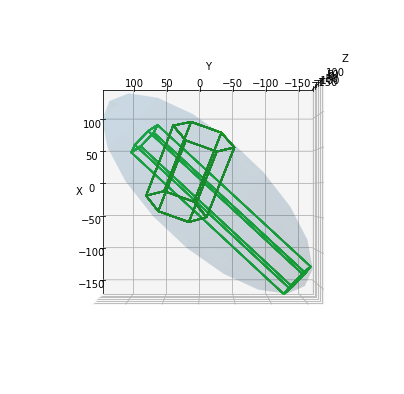

clus 2 7
cluster3 ncrystals 36 7 43
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
clus 1
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42


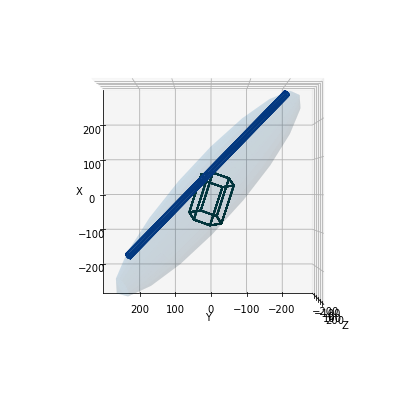

IndexError: list index out of range

i, r  3 12
r =  470.2280362599881 588.9877764341344
ncrystals 21
ncrystals 35
ncrystals 11
nclusters 1 0 23
clus 2 34
cluster3 ncrystals 20 34 54
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
clus 1
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53


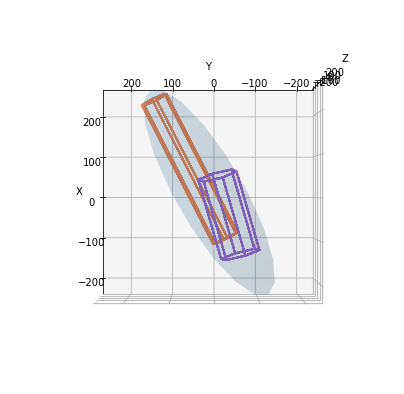

clus 2 10
cluster3 ncrystals 34 10 44
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
clus 1
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43


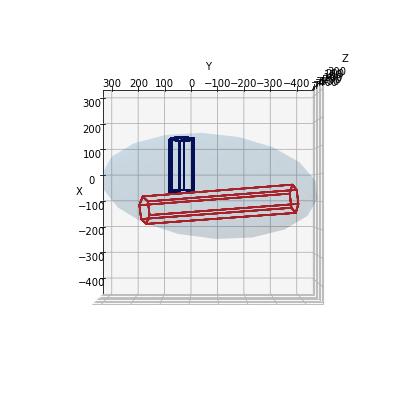

IndexError: list index out of range

i, r  3 13
r =  588.9877764341344 724.5475780136522
ncrystals 35
ncrystals 26
ncrystals 14
nclusters 1 0 23
clus 2 25
cluster3 ncrystals 34 25 59
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
clus 1
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58


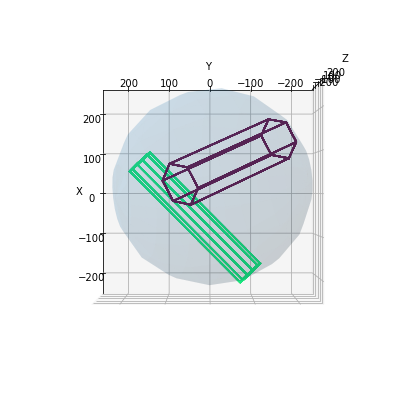

clus 2 13
cluster3 ncrystals 25 13 38
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
clus 1
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37


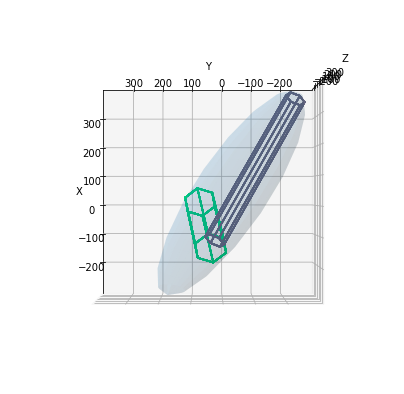

IndexError: list index out of range

i, r  3 14
r =  724.5475780136522 889.3155084555723
ncrystals 28
ncrystals 16
ncrystals 43
nclusters 1 0 23
clus 2 15
cluster3 ncrystals 27 15 42
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
clus 1
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41


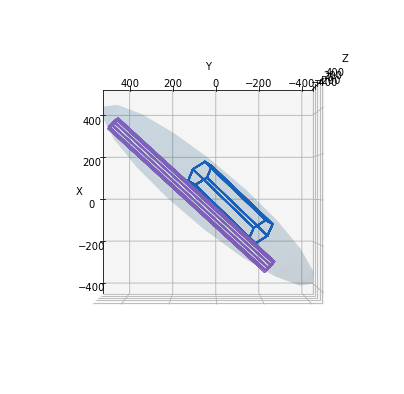

clus 2 42
cluster3 ncrystals 15 42 57
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
clus 1
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56


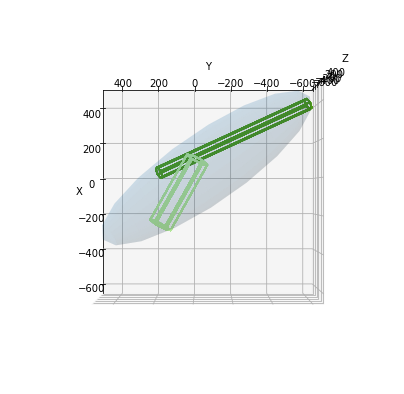

IndexError: list index out of range

i, r  3 15
r =  889.3155084555723 1132.6993797144846
ncrystals 47
ncrystals 13
ncrystals 30
nclusters 1 0 23
clus 2 12
cluster3 ncrystals 46 12 58
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
clus 1
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57


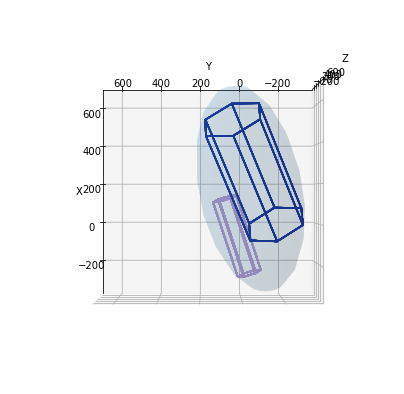

clus 2 29
cluster3 ncrystals 12 29 41
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
clus 1
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40


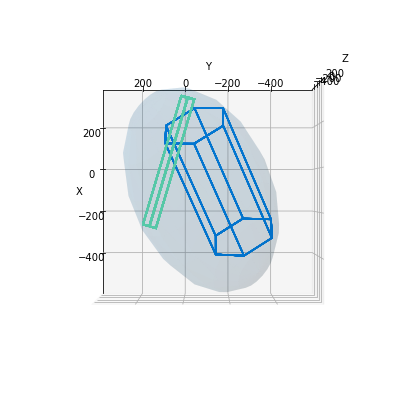

IndexError: list index out of range

i, r  3 16
r =  1132.6993797144846 1649.6649668495015
ncrystals 50
ncrystals 24
ncrystals 46
nclusters 1 0 23
clus 2 23
cluster3 ncrystals 49 23 72
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
clus 1
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71


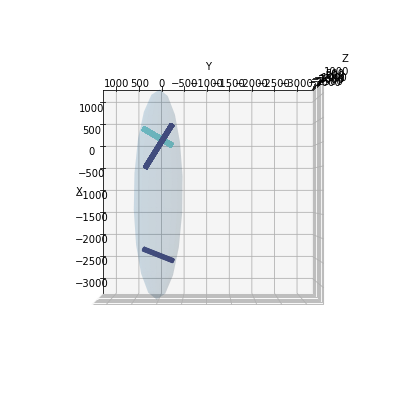

clus 2 45
cluster3 ncrystals 23 45 68
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
clus 1
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67


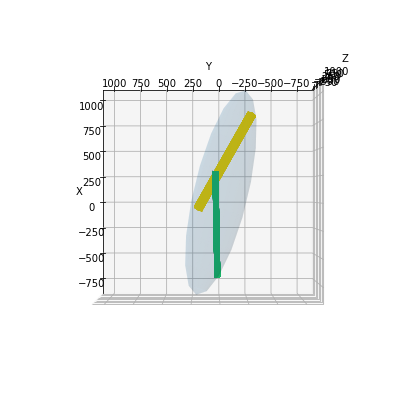

IndexError: list index out of range

i, r  3 17
r =  1649.6649668495015 2566.724417820502
ncrystals 12
ncrystals 36
ncrystals 32
nclusters 1 0 23
clus 2 35
cluster3 ncrystals 11 35 46
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
clus 1
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45


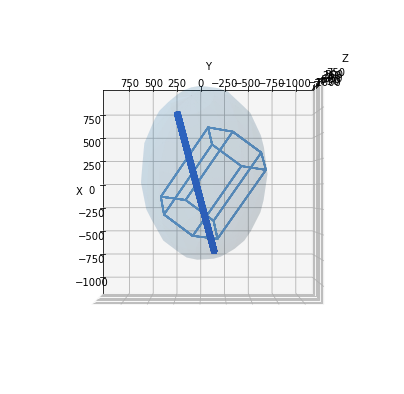

clus 2 31
cluster3 ncrystals 35 31 66
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
clus 1
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65


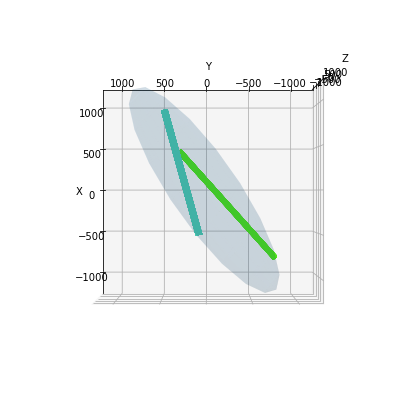

IndexError: list index out of range

i, r  3 18
r =  2566.724417820502 3807.7787912649005
ncrystals 9
ncrystals 44
ncrystals 8
nclusters 1 0 23
clus 2 43
cluster3 ncrystals 8 43 51
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
clus 1
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50


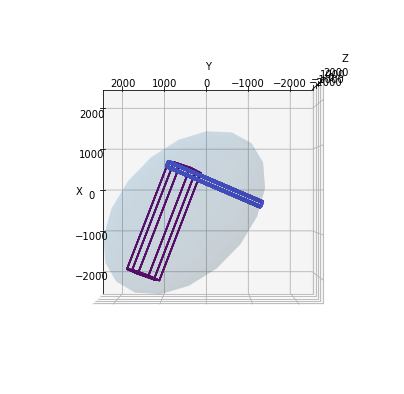

clus 2 7
cluster3 ncrystals 43 7 50
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
clus 1
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49


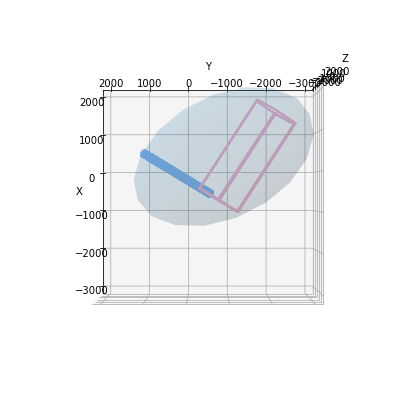

IndexError: list index out of range

i, r  3 19
r =  3807.7787912649005 4999.977911430604
ncrystals 25
ncrystals 34
ncrystals 40
nclusters 1 0 23
clus 2 33
cluster3 ncrystals 24 33 57
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
clus 1
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56


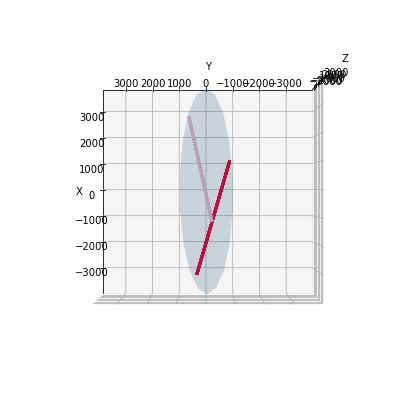

clus 2 39
cluster3 ncrystals 33 39 72
clus 0
crys 0
crys 1
crys 2
crys 3
crys 4
crys 5
crys 6
crys 7
crys 8
crys 9
crys 10
crys 11
crys 12
crys 13
crys 14
crys 15
crys 16
crys 17
crys 18
crys 19
crys 20
crys 21
crys 22
crys 23
crys 24
crys 25
crys 26
crys 27
crys 28
crys 29
crys 30
crys 31
crys 32
clus 1
crys 33
crys 34
crys 35
crys 36
crys 37
crys 38
crys 39
crys 40
crys 41
crys 42
crys 43
crys 44
crys 45
crys 46
crys 47
crys 48
crys 49
crys 50
crys 51
crys 52
crys 53
crys 54
crys 55
crys 56
crys 57
crys 58
crys 59
crys 60
crys 61
crys 62
crys 63
crys 64
crys 65
crys 66
crys 67
crys 68
crys 69
crys 70
crys 71


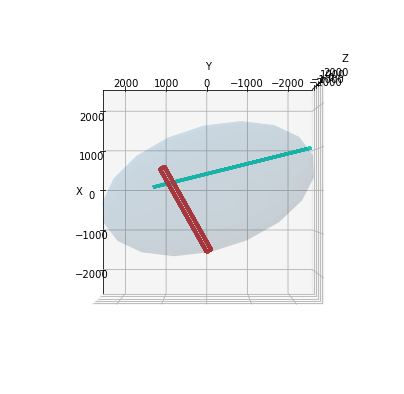

IndexError: list index out of range

In [38]:
clusters = main() 

In [65]:
with parallel_backend("loky"):
    output = Parallel(n_jobs=-1)(delayed(ipas.collect_clusters)(cluster, rand_orient=rand_orient) for cluster in clusters)
    print(output)   

TypeError: 'function' object is not subscriptable

In [ ]:
filename = 'instance_agg_agg_dbtest'
filehandler = open(filename, 'wb')
%time pickle.dump(output, filehandler)
filehandler.close()
print('finished!')

In [40]:
#print(output)
#print('computing...')
start_time = time.time()
#b1 = client.compute(output, scheduler='distributed') 

clusters = iter(output)
futures = [client.submit(ipas.collect_clusters, list(next(clusters)), rand_orient=rand_orient) for i in range(4)]
ac = as_completed(futures)

b1=[]
for finished_future in ac:
    # submit new future 
    try:
        print('submiting a new future')
        new_future = client.submit(ipas.collect_clusters, list(next(clusters)), rand_orient=rand_orient)
        ac.add(new_future)
    except StopIteration:
        pass
    b1.append(finished_future.result())



#print('-------------gathering-----------')
#b1 = client.gather(b1)
print('time to collect = ', (time.time()-start_time))



KeyboardInterrupt: 

In [ ]:
print(b1)

In [34]:
if __name__ == '__main__':

    %time b1 = main() 

    filename = 'instance_agg_agg_dbtest'
    filehandler = open(filename, 'wb')
    %time pickle.dump(b1, filehandler)
    filehandler.close()
    print('finished!')

i, r  0 0
r =  1.7487839568275625 13.844468606238443
time to concatenate all pts =  1.5152053833007812
i, r  0 1
r =  13.844468606238443 23.236377210240864


KeyboardInterrupt: 

NameError: name 'b1' is not defined

finished!


In [ ]:
phiba = b1.rxs/b1.rzs
print(np.shape(phiba))
phica = b1.rys/b1.rzs
ax = sns.jointplot(x=phiba[1,:,2], y=phica[1,:,2], kind='kde')
ax = sns.jointplot(x=phiba[19,:,2], y=phica[19,:,2], kind='kde', color='r')
#ax.set(xlabel='$phi$_ba', ylabel='$phi$_ca')
#ax.set_xlabel('$phi$_ba')
#ax.set_ylabel('$phi$_ca') 